# Return Period

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat
from scipy import stats

import sys

### Training data

# Load the data
# data_file = np.load('max_anomoly_metric.npz')
# data = data_file['data']
dataType = 'Re500_fkx4fky4_r0.1_b0' # Re500_fkx4fky4_r0.1_b20
DATA_DIR = '/home/exouser/Documents/karan/data/' + dataType + '/NoSGS/NX64/dt0.0005_IC1/'
filename = 'omega_extreme_DNS_NX64_dt0.0005_IC1'
dt_data = 5e-2

if dataType == 'Re500_fkx4fky4_r0.1_b20':
    desired_length = 87500
    split_size = 35
elif dataType == 'Re500_fkx4fky4_r0.1_b0':
    desired_length = 30000
    split_size = 12
## Ground Truth

data = loadmat(DATA_DIR + '/' + filename)

omega_max_train = data['Omega_max'].flatten()
omega_min_train = data['Omega_min'].flatten()
omega_std = data['Omega_std'].flatten()

omega_max_normalized = omega_max_train / omega_std
omega_min_normalized = omega_min_train / omega_std

desired_length = 100000
while len(omega_max_normalized) > desired_length:
    omega_max_normalized = omega_max_normalized[:desired_length]
    omega_min_normalized = omega_min_normalized[:desired_length]

split_size = 50
omega_max_normalized_split = np.array_split(omega_max_normalized, split_size)
omega_min_normalized_split = np.array_split(omega_min_normalized, split_size)

model_dir = '../' + dataType + '/2D_64_spectral_dt0.02_noise_2500/'

# Training data
data = np.load(model_dir + 'train_diaagnostics.npz')
omega_max_train = data['Omega_max'].flatten()
omega_min_train = data['Omega_min'].flatten()
omega_max_train_physical_normalized = omega_max_train / omega_std
omega_min_train_physical_normalized = omega_min_train / omega_std

# Emulator data
data = np.load(model_dir + 'model_diaagnostics.npz')
omega_max_model = data['Omega_max'].flatten()
omega_min_model = data['Omega_min'].flatten()
omega_max_model_physical_normalized = omega_max_model / omega_std
omega_min_model_physical_normalized = omega_min_model / omega_std


while len(omega_max_model_physical_normalized) > desired_length:
    omega_max_model_physical_normalized = omega_max_model_physical_normalized[:desired_length]
    omega_min_model_physical_normalized = omega_min_model_physical_normalized[:desired_length]

omega_max_model_normalized_split = np.array_split(omega_max_model_physical_normalized, split_size)
omega_min_model_normalized_split = np.array_split(omega_min_model_physical_normalized, split_size)


# Return Period of Time Series (no uncertainity)

/tmp/ipykernel_1085589/1381789304.py:14: RuntimeWarning: divide by zero encountered in divide
  return 1/(1-freq_total)*dt, freq_total, bins


Text(0, 0.5, 'Return Period')

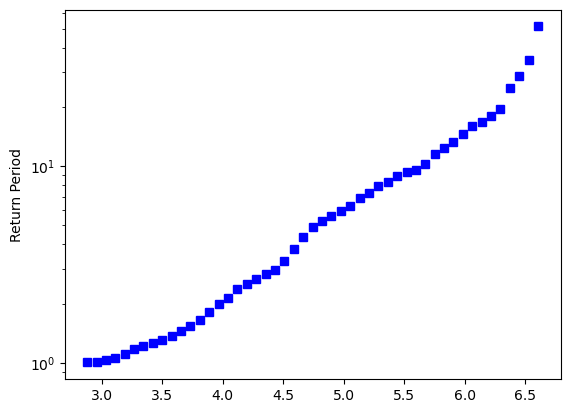

In [3]:
def return_period(data, dt=1, bins=50, bin_range=None):
    '''
    Return period for a time series data
    Inverse of the exedance probability
    https://www.pnas.org/doi/full/10.1073/pnas.1716222114'''

    freq, bins = np.histogram(data, bins=bins, range=bin_range)
    bins = (bins[1:] + bins[:-1]) / 2
    freq_total = np.zeros(freq.shape)
    for count, value in enumerate(freq):
        freq_total[count] = np.sum(freq[:count+1])
    freq_total = freq_total / np.sum(freq)

    return 1/(1-freq_total)*dt, freq_total, bins


return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized_split)[0,:], bins=50)
plt.semilogy(bins_max, return_period_kerry, 'sb')
plt.ylabel('Return Period')

# Return Period of Ensemble (with uncertainity)


In [4]:
def ci_t_distribution(data, confidence_level):
    """
    Calculate confidence intervals using the t-distribution.

    Parameters:
    - data: 2D NumPy array of shape (N, samples)
    - confidence_level: float between 0 and 1 representing the confidence level

    Returns:
    - means: array of sample means
    - lower_bounds: array of lower bounds of the confidence intervals
    - upper_bounds: array of upper bounds of the confidence intervals
    """
    N = data.shape[0]  # Number of ensembles
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0, ddof=1)  # Sample standard deviation with Bessel's correction
    SEMs = stds / np.sqrt(N)  # Standard Error of the Mean
    df = N - 1  # Degrees of freedom
    alpha = 1 - confidence_level
    # Critical t-value
    t_crit = stats.t.ppf(1 - alpha / 2, df)
    print(t_crit)
    margin_of_error = t_crit * SEMs
    margin_of_error = 1*stds
    lower_bounds = means - margin_of_error
    upper_bounds = means + margin_of_error
    return means, lower_bounds, upper_bounds

def ci_normal_distribution(data, confidence_level):
    """
    Calculate confidence intervals using the normal (z) distribution.

    Parameters:
    - data: 2D NumPy array of shape (N, samples)
    - confidence_level: float between 0 and 1 representing the confidence level

    Returns:
    - means: array of sample means
    - lower_bounds: array of lower bounds of the confidence intervals
    - upper_bounds: array of upper bounds of the confidence intervals
    """
    N = data.shape[0]  # Number of ensembles
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0, ddof=1)
    SEMs = stds / np.sqrt(N)
    alpha = 1 - confidence_level
    # Critical z-value
    z_crit = stats.norm.ppf(1 - alpha / 2)
    print(z_crit)
    margin_of_error = z_crit * SEMs
    lower_bounds = means - margin_of_error
    upper_bounds = means + margin_of_error
    return means, lower_bounds, upper_bounds

def return_period(data, dt=1, bins=50, bin_range=None):
    '''
    Return period for a time series data
    Inverse of the exceedance probability
    '''
    # Compute histogram frequencies and bin edges
    freq, bin_edges = np.histogram(data, bins=bins, range=bin_range)
    # Compute bin centers
    bins_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    # Compute cumulative frequencies from the highest bin downwards
    freq_exceedance = np.cumsum(freq[::-1])[::-1]
    # Total number of data points
    total_data_points = len(data)
    # Calculate exceedance probabilities
    prob_exceedance = freq_exceedance / total_data_points
    # Avoid division by zero in return period calculation
    prob_exceedance = np.clip(prob_exceedance, 1e-14, 1)
    # Calculate return periods
    return_periods = dt / prob_exceedance
    return return_periods, prob_exceedance, bins_centers

def return_period_ensemble(data, dt=1, bins=50, uncertainty='freq_exceedance',
                           confidence_level=0.975):
    '''
    Calculate return period using ensemble of data
    data: 2D array of data [ensemble, time]
    dt: time step
    bins: number of bins for binning the data
    uncertainty: 'freq' / 'freq_exceedance': 
        Determines whether uncertainty is calculated based on frequency or frequency exceedance
    confidence_level: Percentage for the confidence interval (e.g., 95 for 95% confidence interval)
    '''
    number_ensemble = data.shape[0]
    total_data_points = data.shape[1]
    
    bin_min = np.min(data)
    bin_max = np.max(data)
    
    # Initialize lists to store per-ensemble probabilities
    prob_exceedance_ensemble = []
    freq_ensemble = []

    bins_centers = None  # Will be set during the first iteration

    for i in range(number_ensemble):
        data_ensemble = data[i, :]
        freq_sample, bin_edges = np.histogram(data_ensemble, bins=bins, range=(bin_min, bin_max))
        if bins_centers is None:
            bins_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        freq_exceedance_sample = np.cumsum(freq_sample[::-1])[::-1]
        prob_exceedance_sample = freq_exceedance_sample / total_data_points

        freq_ensemble.append(freq_sample)
        prob_exceedance_ensemble.append(prob_exceedance_sample)

    freq_ensemble = np.array(freq_ensemble)
    prob_exceedance_ensemble = np.array(prob_exceedance_ensemble)

    # Calculate uncertainty based on the selected method
    if uncertainty == 'freq':
        # Average frequencies and compute probabilities from the mean frequencies
        freq_mean = np.mean(freq_ensemble, axis=0)

        # Compute cumulative frequencies
        freq_exceedance_mean = np.cumsum(freq_mean[::-1])[::-1]

        # Calculate exceedance probabilities
        prob_exceedance_mean = freq_exceedance_mean / (total_data_points * number_ensemble)

        # Calculate confidence intervals for frequencies
        lower_percentile = (100 - confidence_level) / 2
        upper_percentile = 100 - lower_percentile

        freq_exceedance_lower = np.percentile(np.cumsum(freq_ensemble[:, ::-1], axis=1)[:, ::-1],
                                              lower_percentile, axis=0)
        freq_exceedance_upper = np.percentile(np.cumsum(freq_ensemble[:, ::-1], axis=1)[:, ::-1],
                                              upper_percentile, axis=0)

        # Calculate exceedance probabilities for confidence intervals
        prob_exceedance_lower = freq_exceedance_lower / (total_data_points)
        prob_exceedance_upper = freq_exceedance_upper / (total_data_points)

    elif uncertainty == 'freq_exceedance':
        # Calculate mean of probabilities directly
        prob_exceedance_mean, prob_exceedance_lower, prob_exceedance_upper = ci_t_distribution(prob_exceedance_ensemble, confidence_level)
        # prob_exceedance_mean, prob_exceedance_lower, prob_exceedance_upper = ci_normal_distribution(prob_exceedance_ensemble, confidence_level)

    else:
        raise ValueError("Invalid uncertainty method. Choose 'freq' or 'freq_exceedance'.")
    
    # print(prob_exceedance_mean)
    # print(prob_exceedance_lower)
    # print(prob_exceedance_upper)

    # Ensure probabilities are within valid range
    x = np.clip(prob_exceedance_mean, 1e-14, 1)
    prob_exceedance_lower = np.clip(prob_exceedance_lower, 1e-14, 1)
    prob_exceedance_upper = np.clip(prob_exceedance_upper, 1e-14, 1)

    # Calculate return periods
    return_period_mean = dt / prob_exceedance_mean
    return_period_lower = dt / prob_exceedance_upper  # Higher probability, lower return period
    return_period_upper = dt / prob_exceedance_lower  # Lower probability, higher return period

    return return_period_mean, return_period_lower, return_period_upper, bins_centers


2.3123751638001577
2.3123751638001577
2.3123751638001577
2.3123751638001577


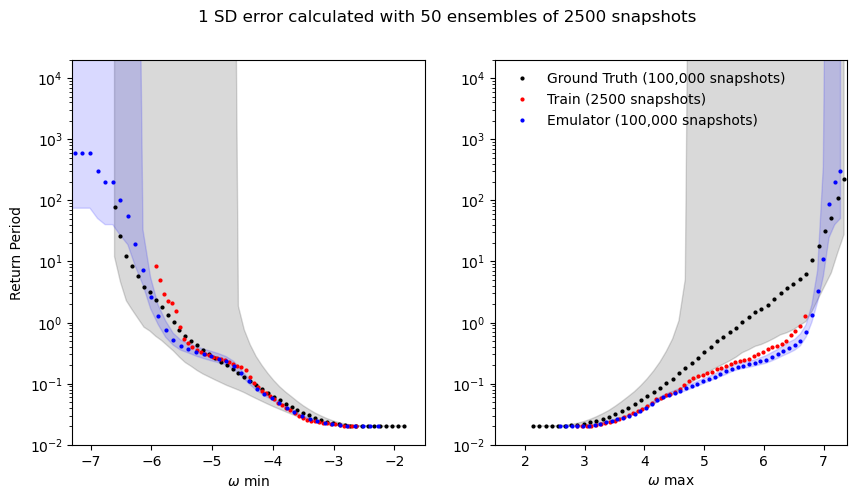

In [41]:
dt = 0.02
ensemble_num = 80
markersize = 2
bin_num = 50
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

file_range = [110000, 112500]


### Omega min

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized[file_range[0]:file_range[1]]), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'ok', label='Ground Truth (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized_split).flatten(), dt=dt, bins=bin_num)
axes[0].semilogy(-bins_max, return_period_kerry, 'ok', label='Ground Truth (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'ob', label='Model (300,000 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_train_physical_normalized), dt=dt, bins=bin_num)
axes[0].semilogy(-bins_max, return_period_kerry, 'or', label='Train (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_physical_normalized), dt=dt, bins=bin_num)
axes[0].semilogy(-bins_max, return_period_kerry, 'ob', label='Emulator  (2500 snapshots)', markersize=markersize)


# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_train_spectral_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, '^m', label='Train (spectral) (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_spectral_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, '^g', label='Model (spectral) (2500 snapshots)', markersize=markersize)



# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized_split)[ensemble_num,:], dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'or', label='Training Data (2500 snapshots)', markersize=markersize)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(omega_min_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='k', alpha=0.15)
# axes[0].semilogy(-bins, return_period_mean, 'ok', label='Mean + 97.5% CI with 200 ensembles of chunks of 2500 snapshots', markersize=markersize)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(omega_min_model_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[0].fill_between(-bins, return_period_min, return_period_max, color='b', alpha=0.15)
# axes[0].semilogy(-bins, return_period_mean, 'ob', label='Mean + 97.5% CI with 200 ensembles of chunks of 2500 snapshots', markersize=markersize)

axes[0].set_xlabel('$\omega$ min')
axes[0].set_ylabel('Return Period')


### Omega max

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized[file_range[0]:file_range[1]]), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ok', label='Ground Truth (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized_split).flatten(), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'ok', label='Ground Truth (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ob', label='Model (300,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized_split)[ensemble_num,:], dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'or', label='Training Data (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_train_physical_normalized), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'or', label='Train (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_physical_normalized), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'ob', label='Emulator (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_train_spectral_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, '^m', label='Train (spectral) (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_spectral_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, '^g', label='Model (spectral) (2500 snapshots)', markersize=markersize)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.asarray(omega_max_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[1].fill_between(bins, return_period_min, return_period_max, color='k', alpha=0.15)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.asarray(omega_max_model_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[1].fill_between(bins, return_period_min, return_period_max, color='b', alpha=0.15)

axes[1].set_xlabel('$\omega$ max')

for ax in axes.flatten():
    ax.set_ylim([1e-2, 2e4])
axes[0].set_xlim([-7.3, -1.5])
axes[1].set_xlim([1.5, 7.4])
plt.suptitle('1 SD error calculated with 50 ensembles of 2500 snapshots')
axes[1].legend(loc='upper left', frameon=False)

## Calculate Return Period for a dataset

In [17]:
# from scipy.io import savemat

# from py2d.convert import UV2Omega
# from py2d.initialize import initialize_wavenumbers_rfft2, gridgen

# model_dir = '../2D_32_dt0.02_noise_25000/'
# model_batch_num = 25
# model_data_dir  = model_dir + 'data/'

# # Define the domain size and number of grid points
# Lx, Ly = 2*np.pi, 2*np.pi # Domain size
# Nx, Ny = 32,32 # Number of grid points

# # Generate grid with given domain size and number of grid points
# Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')
# # Initialize wavenumbers for 2D Fourier-based pseudo-spectral differentiation
# Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(Nx, Ny, Lx, Ly, INDEXING='ij')

# U_arr = []
# V_arr = []
# Omega_arr = []

# U_max_arr, U_min_arr = [], []
# V_max_arr, V_min_arr = [], []
# Omega_max_arr, Omega_min_arr = [], []

# for count_model in range(model_batch_num):
#     print(count_model)
#     model_batch = np.load(model_data_dir + f'{count_model}.npy')

#     for count in range(model_batch.shape[0]):
#         data_U = model_batch[count,0,:,:]
#         data_V = model_batch[count,1,:,:]
#         data_Omega = UV2Omega(data_U, data_V, Kx, Ky, spectral=False)

#         U_max_arr.append(np.max(data_U))
#         U_min_arr.append(np.min(data_U))
#         V_max_arr.append(np.max(data_V))
#         V_min_arr.append(np.min(data_V))
#         Omega_max_arr.append(np.max(data_Omega))
#         Omega_min_arr.append(np.min(data_Omega))

#         if count < 100:
#             Omega_arr.append(data_Omega)
#             U_arr.append(data_U)
#             V_arr.append(data_V)



# U_mean, U_std = np.mean(U_arr), np.std(U_arr)
# V_mean, V_std = np.mean(V_arr), np.std(V_arr)
# Omega_mean, Omega_std = np.mean(Omega_arr), np.std(Omega_arr)

# savemat(model_dir + 'extreme_values.mat', {'Omega_max': Omega_max_arr, 'Omega_min': Omega_min_arr, 'Omega_mean': Omega_mean, 'Omega_std': Omega_std,
#                                                 'U_max': U_max_arr, 'U_min': U_min_arr, 'U_mean': U_mean, 'U_std': U_std,
#                                                 'V_max': V_max_arr, 'V_min': V_min_arr, 'V_mean': V_mean, 'V_std': V_std})

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Sample data
# mean = 50
# sd = 10
# N = 100
# sem = sd / np.sqrt(N)
# z_value = 1  # For 68% confidence interval

# # ±1 SD interval
# sd_lower = mean - sd
# sd_upper = mean + sd

# # 68% Confidence Interval
# ci_lower = mean - z_value * sem
# ci_upper = mean + z_value * sem

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.axhline(mean, color='black', linestyle='-', label='Sample Mean')
# plt.fill_between([0, 1], sd_lower, sd_upper, color='blue', alpha=0.2, label='±1 SD Interval')
# plt.fill_between([0, 1], ci_lower, ci_upper, color='green', alpha=0.4, label='68% Confidence Interval')
# plt.xlim(0, 1)
# plt.ylim(mean - 3 * sd, mean + 3 * sd)
# plt.legend()
# plt.title('Comparison of ±1 SD Interval and 68% Confidence Interval')
# plt.ylabel('Value')
# plt.xticks([])
# plt.show()


2.3123751638001577
2.3123751638001577


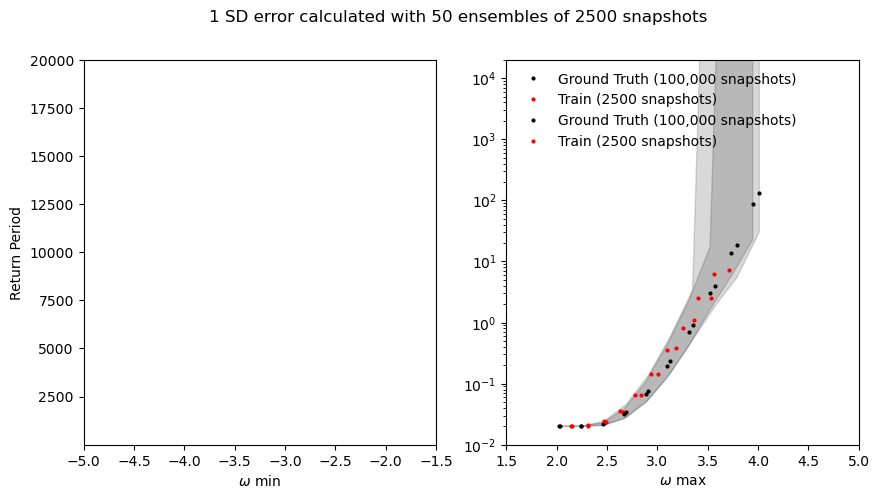

In [23]:
dt = 0.02
ensemble_num = 80
markersize = 2
bin_num = 10
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

file_range = [110000, 112500]


### Omega min

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized[file_range[0]:file_range[1]]), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'ok', label='Ground Truth (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized_split).flatten(), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'ok', label='Ground Truth (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'ob', label='Model (300,000 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_train_physical_normalized), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'or', label='Train (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_physical_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ob', label='Emulator  (2500 snapshots)', markersize=markersize)


# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_train_spectral_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, '^m', label='Train (spectral) (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_model_spectral_normalized), dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, '^g', label='Model (spectral) (2500 snapshots)', markersize=markersize)



# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_min_normalized_split)[ensemble_num,:], dt=dt, bins=bin_num)
# axes[0].semilogy(-bins_max, return_period_kerry, 'or', label='Training Data (2500 snapshots)', markersize=markersize)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.abs(omega_min_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[1].fill_between(bins, return_period_min, return_period_max, color='k', alpha=0.15)
# axes[0].semilogy(-bins, return_period_mean, 'ok', label='Mean + 97.5% CI with 200 ensembles of chunks of 2500 snapshots', markersize=markersize)

# return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
#     np.abs(omega_min_model_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
# axes[1].fill_between(bins, return_period_min, return_period_max, color='b', alpha=0.15)
# axes[0].semilogy(-bins, return_period_mean, 'ob', label='Mean + 97.5% CI with 200 ensembles of chunks of 2500 snapshots', markersize=markersize)

axes[0].set_xlabel('$\omega$ min')
axes[0].set_ylabel('Return Period')


### Omega max

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized[file_range[0]:file_range[1]]), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ok', label='Ground Truth (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized_split).flatten(), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'ok', label='Ground Truth (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ob', label='Model (300,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_normalized_split)[ensemble_num,:], dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'or', label='Training Data (2500 snapshots)', markersize=markersize)

return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_train_physical_normalized), dt=dt, bins=bin_num)
axes[1].semilogy(bins_max, return_period_kerry, 'or', label='Train (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_physical_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, 'ob', label='Emulator (100,000 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_train_spectral_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, '^m', label='Train (spectral) (2500 snapshots)', markersize=markersize)

# return_period_kerry, freq_tot, bins_max = return_period(np.abs(omega_max_model_spectral_normalized), dt=dt, bins=bin_num)
# axes[1].semilogy(bins_max, return_period_kerry, '^g', label='Model (spectral) (2500 snapshots)', markersize=markersize)

return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
    np.asarray(omega_max_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
axes[1].fill_between(bins, return_period_min, return_period_max, color='k', alpha=0.15)

# return_period_mean, return_period_min, return_period_max, bins = return_period_ensemble(
#     np.asarray(omega_max_model_normalized_split), dt=dt, bins=bin_num, uncertainty='freq_exceedance')
# axes[1].fill_between(bins, return_period_min, return_period_max, color='b', alpha=0.15)

axes[1].set_xlabel('$\omega$ max')

for ax in axes.flatten():
    ax.set_ylim([1e-2, 2e4])
axes[0].set_xlim([-5, -1.5])
axes[1].set_xlim([1.5, 5])
plt.suptitle('1 SD error calculated with 50 ensembles of 2500 snapshots')
axes[1].legend(loc='upper left', frameon=False)